In [7]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import cmocean
import cartopy
import cartopy.crs as ccrs
import math
import cmaps
import cftime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import utils

In [11]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("/home/ghervieux/SCRIPTS/PSANCT/cma.mplstyle")

# Define variables and paths

In [8]:
var='Temp'
units='$\degree$C'
dirin='/data/ghervieux/NG_NMS'
cruise='PnB'

# Read PnB Temp file

In [4]:
DS=xr.open_dataset(f'{dirin}/PnB_{var}.nc')
DS['time']

<xarray.DataArray 'time' (time: 324)>
array(['1993-01-15T00:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-15T00:00:00.000000000', ..., '2019-10-15T00:00:00.000000000',
       '2019-11-15T00:00:00.000000000', '2019-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2019-12-15

# Extract JAS 

In [5]:
DSjas=DS.sel(time=DS.time.dt.month.isin([7,8,9]))
obs=DSjas['obs']
glo=DSjas['GLORYS'].where(DSjas['GLORYS']>0)
nep=DSjas['NEP'].where(DSjas['NEP']>0)
depth=DS['depth']
timejas=DS['time']

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [6]:
depth

<xarray.DataArray 'depth' (depth: 100)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99

# Plot JAS Taylor Diagram

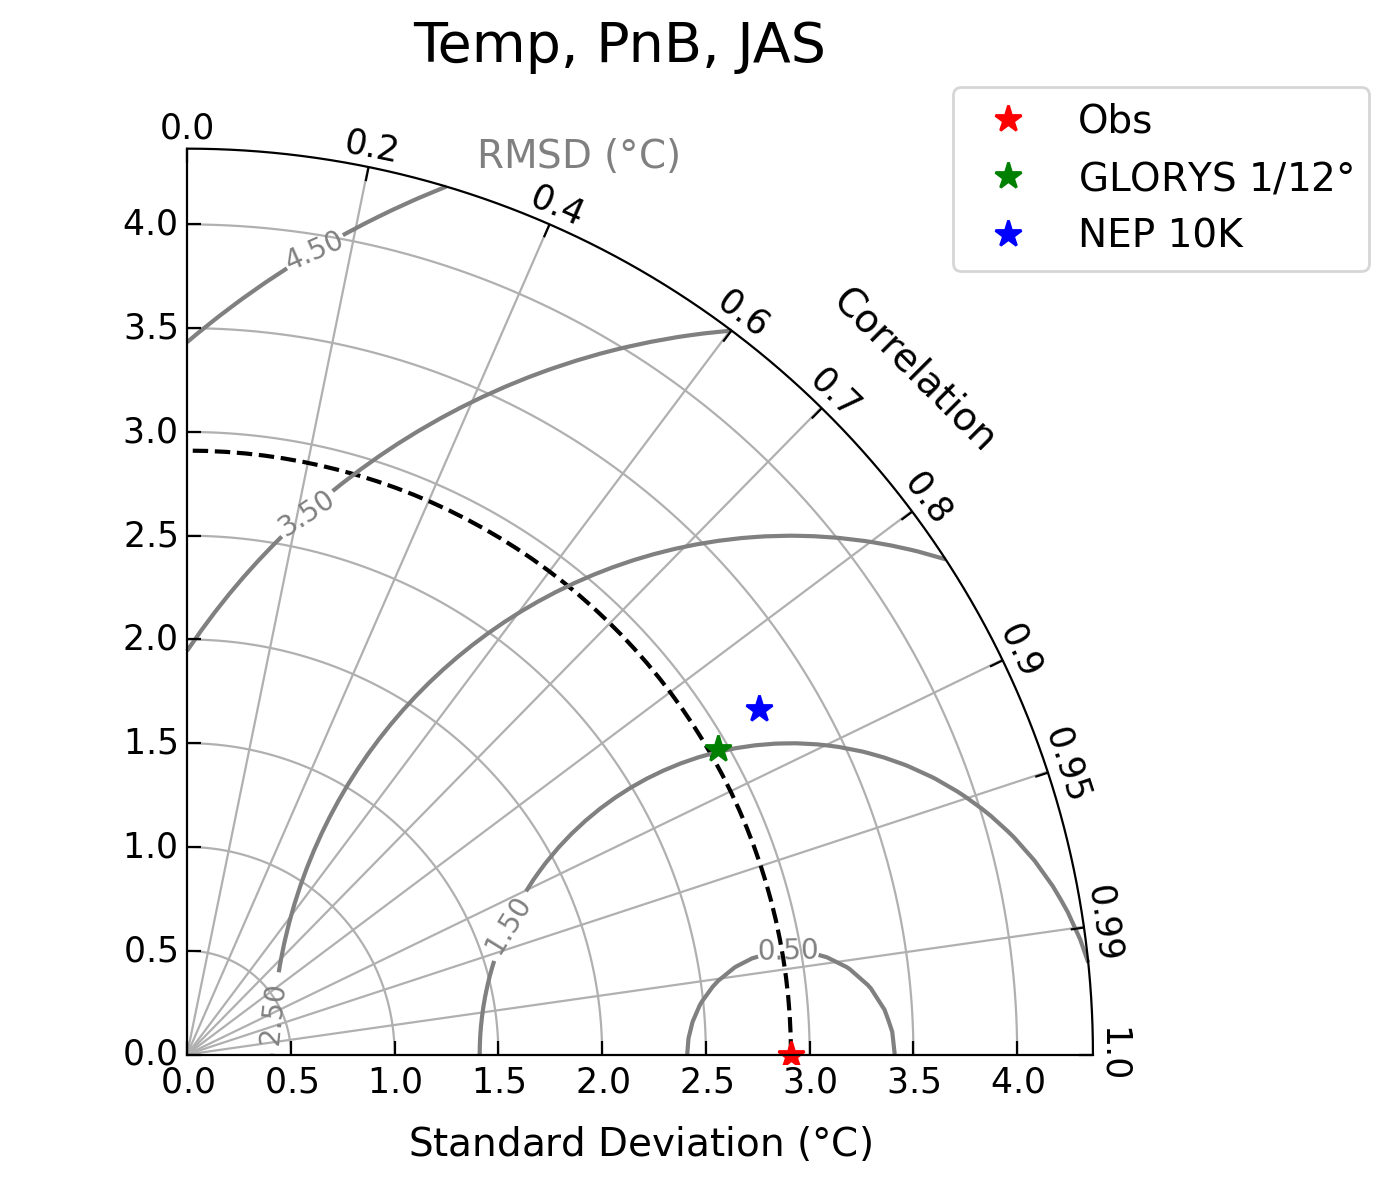

In [12]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2
# Compute stddev and correlation coefficient of models
samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])



fig,axs = plt.subplots(nrows=1,ncols=1)
dia = utils.TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                    srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef, \
                    marker='*', ms=10, ls='', \
                    mfc=colors[i], mec=colors[i], \
                    label=labels[i])
# Add grid
dia.add_grid()
# Add a figure legend
fig.legend(dia.samplePoints,
            [ p.get_label() for p in dia.samplePoints ],
            numpoints=1, loc='upper right',\
                    bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
            ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
            va='center',fontsize=14,rotation=315)
plt.text(0.45,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
            rotation=0,ha='center',fontsize=14)
axs.axis('off')
plt.suptitle(f'{var}, {cruise}, JAS',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_{var}_TaylorDiagram.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')


# PLOT JAS Scatter Plot

/tmp/ipykernel_3909941/1314937325.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)


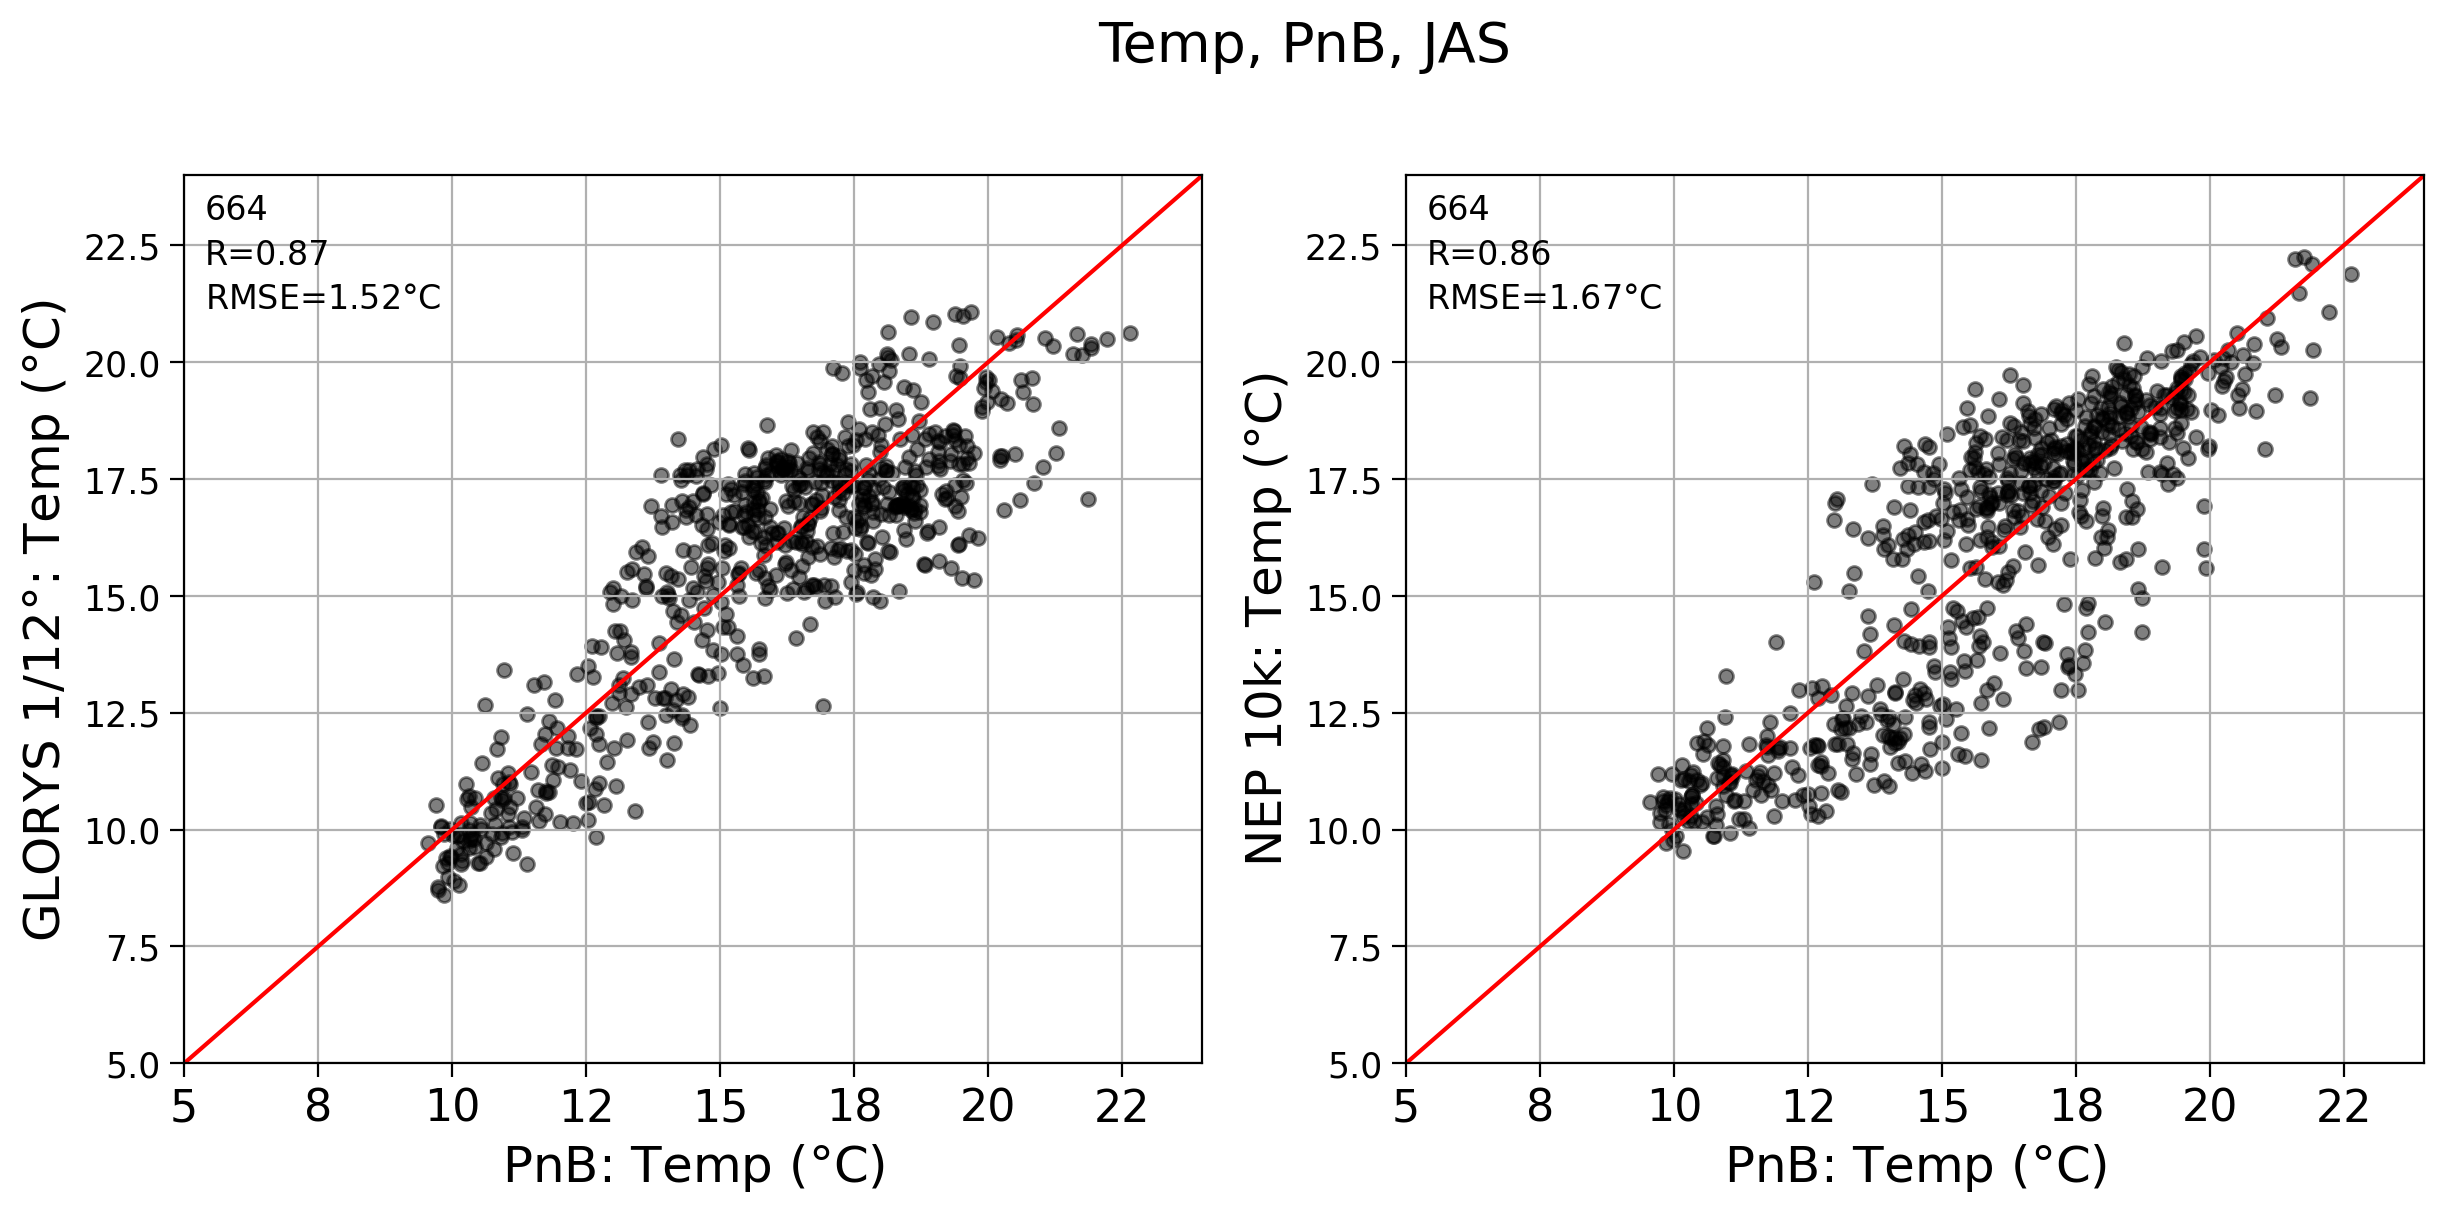

In [13]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,left=0.1,top=0.85,wspace=0.2)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)

axs[0].text(0.02, 0.95,f'{len(xxx1)}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'{len(xxx2)}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)

for i in range(len(axs)):
    axs[i].set_ylim(5,24)
    axs[i].set_xlim(5,24)
    axs[i].grid()
    axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
    axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
    axs[i].set_xlabel(f'{cruise}: {var} ({units})',fontsize=18)

axs[0].set_ylabel(f'GLORYS 1/12$\degree$: {var} ({units})',fontsize=18)
axs[1].set_ylabel(f'NEP 10k: {var} ({units})',fontsize=18)

plt.suptitle(f'{var}, {cruise}, JAS',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_{var}_Scatter.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Read the full time

In [22]:
DS=DS.sel(time=slice('1996-01-01','2019-12-31'))
obs=DS['obs']
glo=DS['GLORYS'].where(DS['GLORYS']>0)
nep=DS['NEP'].where(DS['NEP']>0)
depth=DS['depth']
time=DS['time']

/tmp/ipykernel_3909941/1341692102.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
/tmp/ipykernel_3909941/1341692102.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
/tmp/ipykernel_3909941/1341692102.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
/tmp/ipykernel_3909941/1341692102.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
/tmp/ipykernel_3909941/1341692102.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
/tmp/ipykernel_3909941/1341692102.py:18: UserWarning: FixedFormatter should only be used togeth

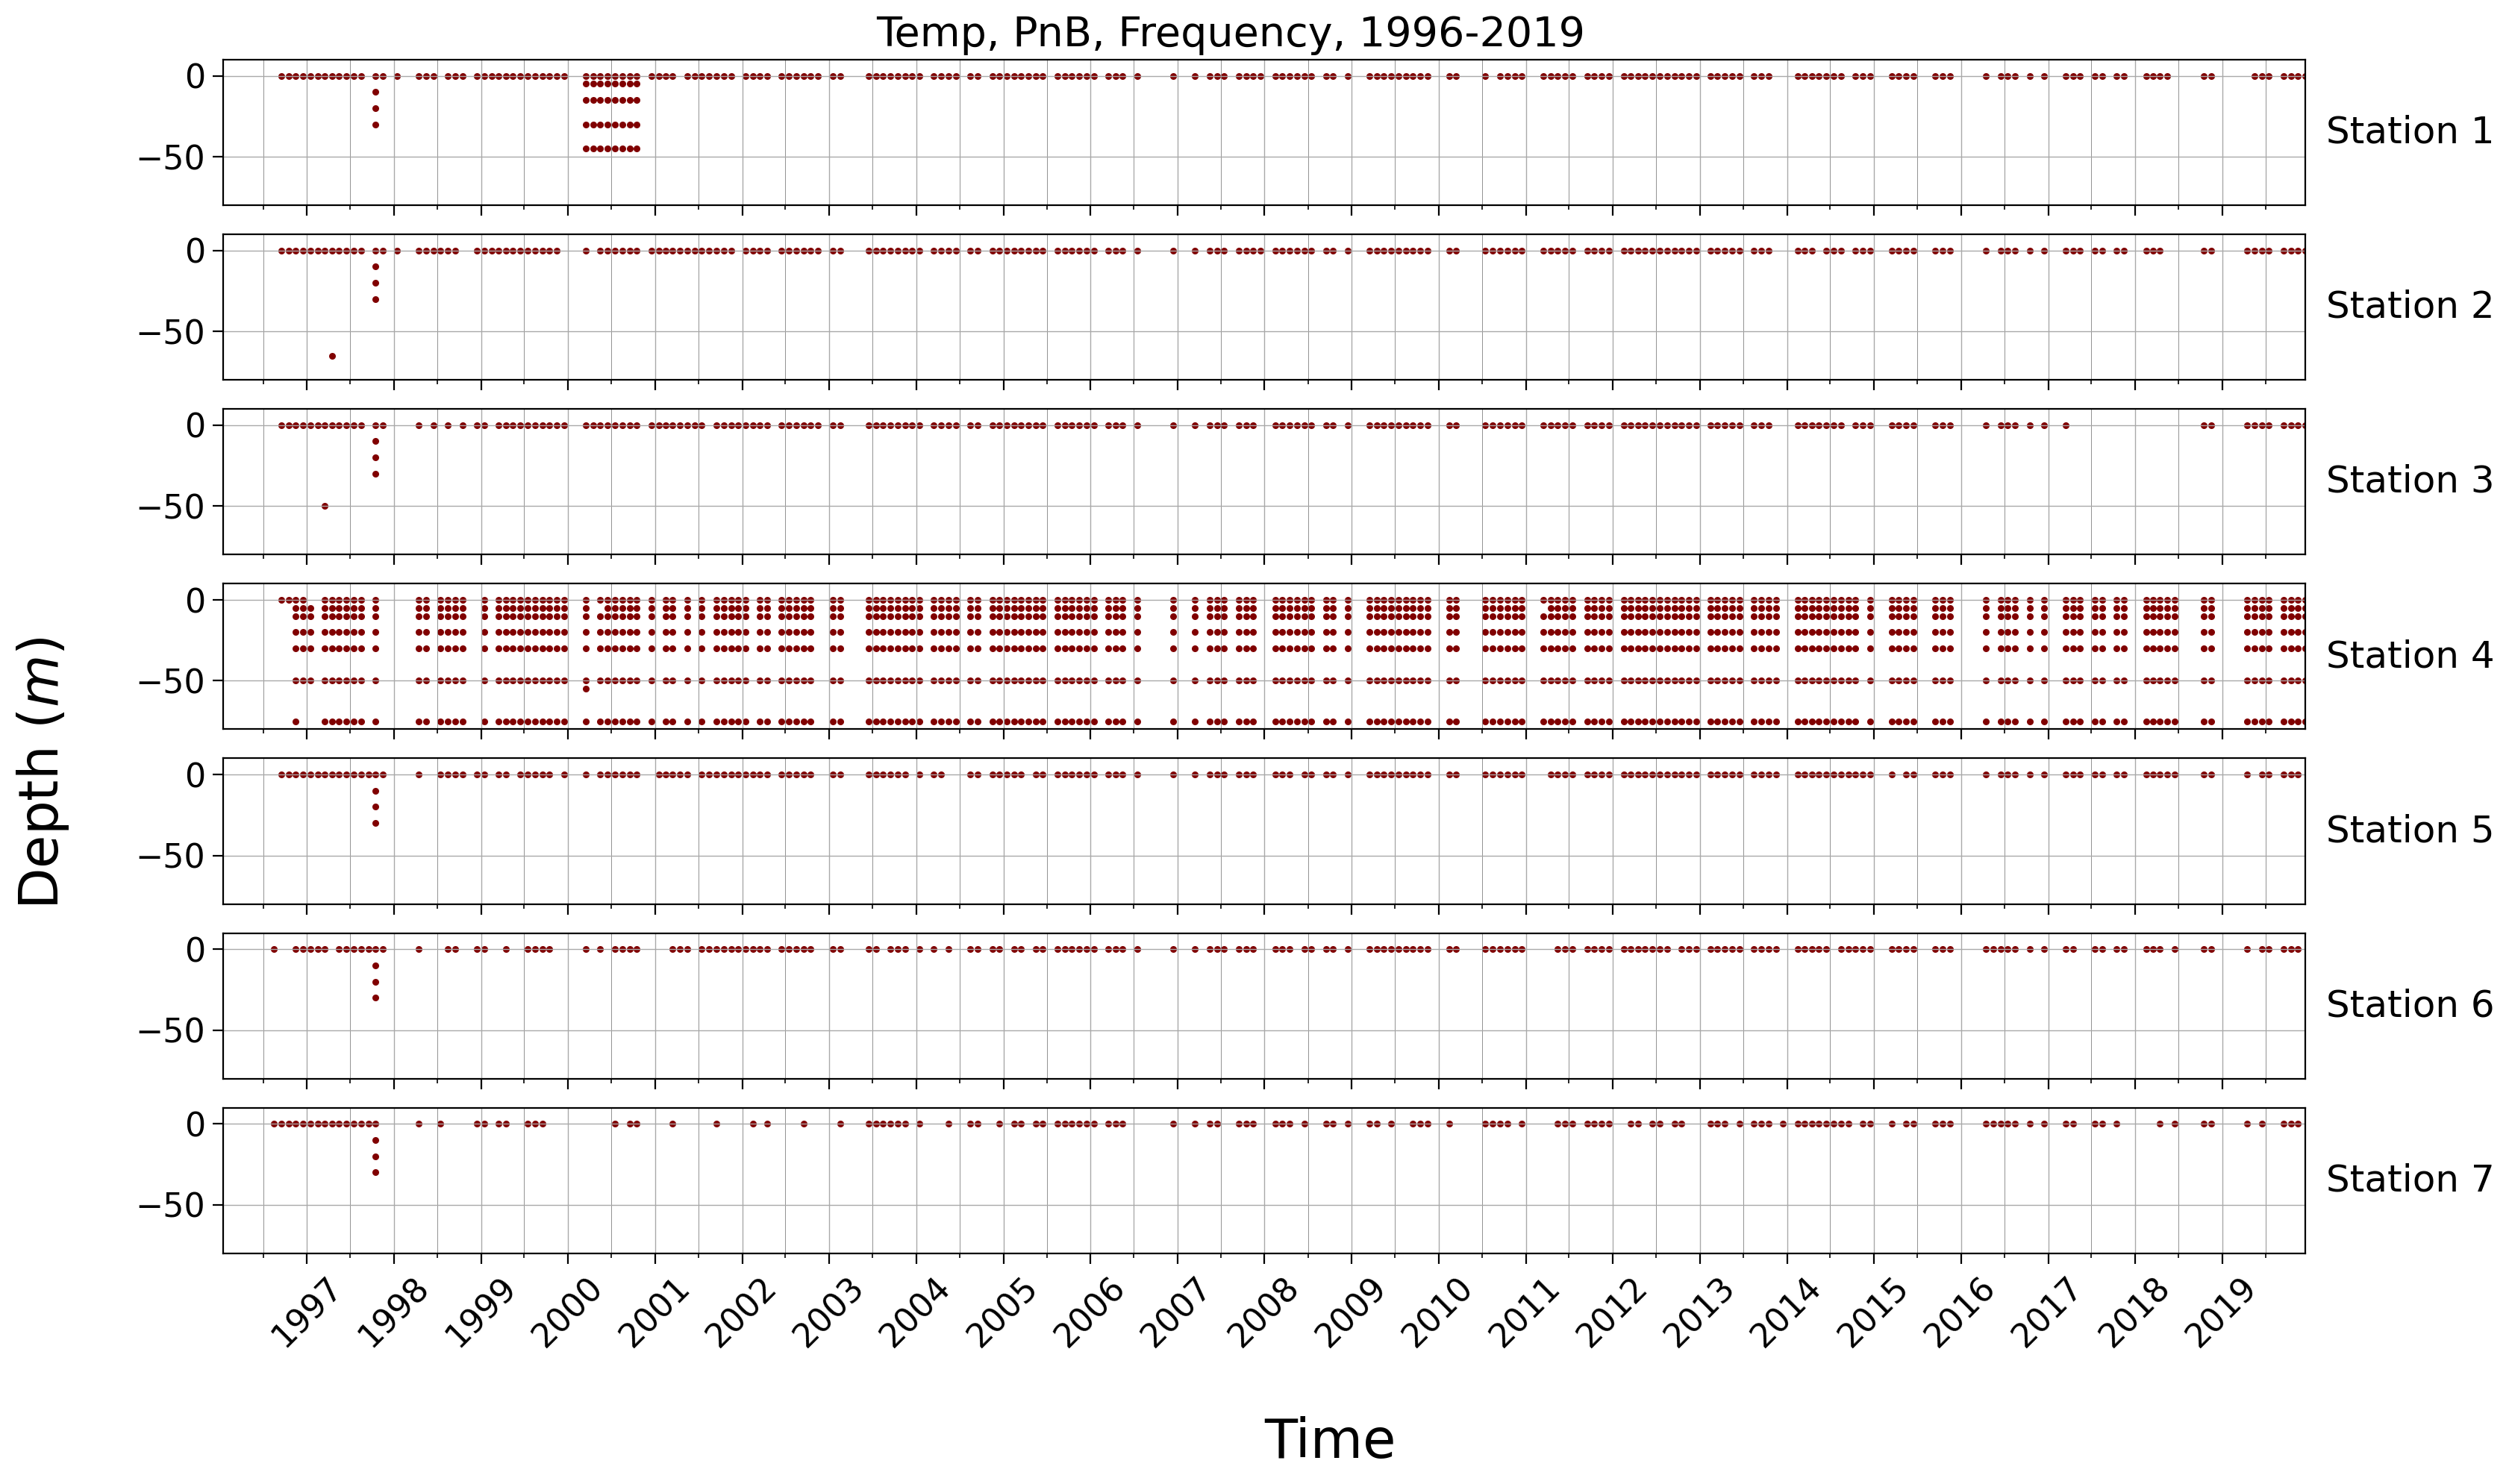

In [23]:

statimedepth=xr.ones_like(obs).where(np.isnan(obs)==False)
fig, axs =plt.subplots(nrows=len(DS['npts']),ncols=1,
                    figsize=(18,10),num=5,clear=True)
plt.subplots_adjust(bottom=0.15, right=0.9, top=0.95,hspace=0.2)
for ix in range(0,len(DS['npts'])):
  idtime,iddep=np.where(statimedepth[:,:,ix]==1)
  ccT=axs[ix].scatter(DS['time'][idtime],-depth[iddep],s=5,c='maroon')
  plt.text(1.01, 0.5, f'Station {ix+1}',\
                    transform=axs[ix].transAxes,\
                rotation='horizontal',va='center',fontsize=18)
  axs[ix].set_ylim(-80,10)
  axs[ix].set_title('')
  axs[ix].xaxis.set_minor_locator(mdates.MonthLocator(7))
  axs[ix].xaxis.set_major_locator(mdates.YearLocator(month=1))
  axs[ix].grid(which='major', color='darkgrey', linewidth=0.5)
  axs[ix].grid(which='minor', color='grey', linewidth=0.3)
  axs[ix].set_xlim(time[0],time[-1])
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
  if ix==len(DS['npts'])-1:
    axs[ix].set_xticklabels(axs[ix].get_xticklabels(),rotation=45,fontsize=16)
  else:
    axs[ix].set_xticklabels('')
plt.text(-0.1, 0.9, f'Depth ($m$)',transform=axs[round(len(DS['npts'])/2)].transAxes,\
            rotation='vertical',va='center',fontsize=26)
plt.text(0.5, -1.3, f'Time',transform=axs[len(DS['npts'])-1].transAxes,\
              va='center',fontsize=26)
plt.suptitle(f'{var}, PnB, Frequency, 1996-2019',fontsize=20)
outfile=f'PLOTS/PnB_{var}_frequency.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Plot Taylor Diagram

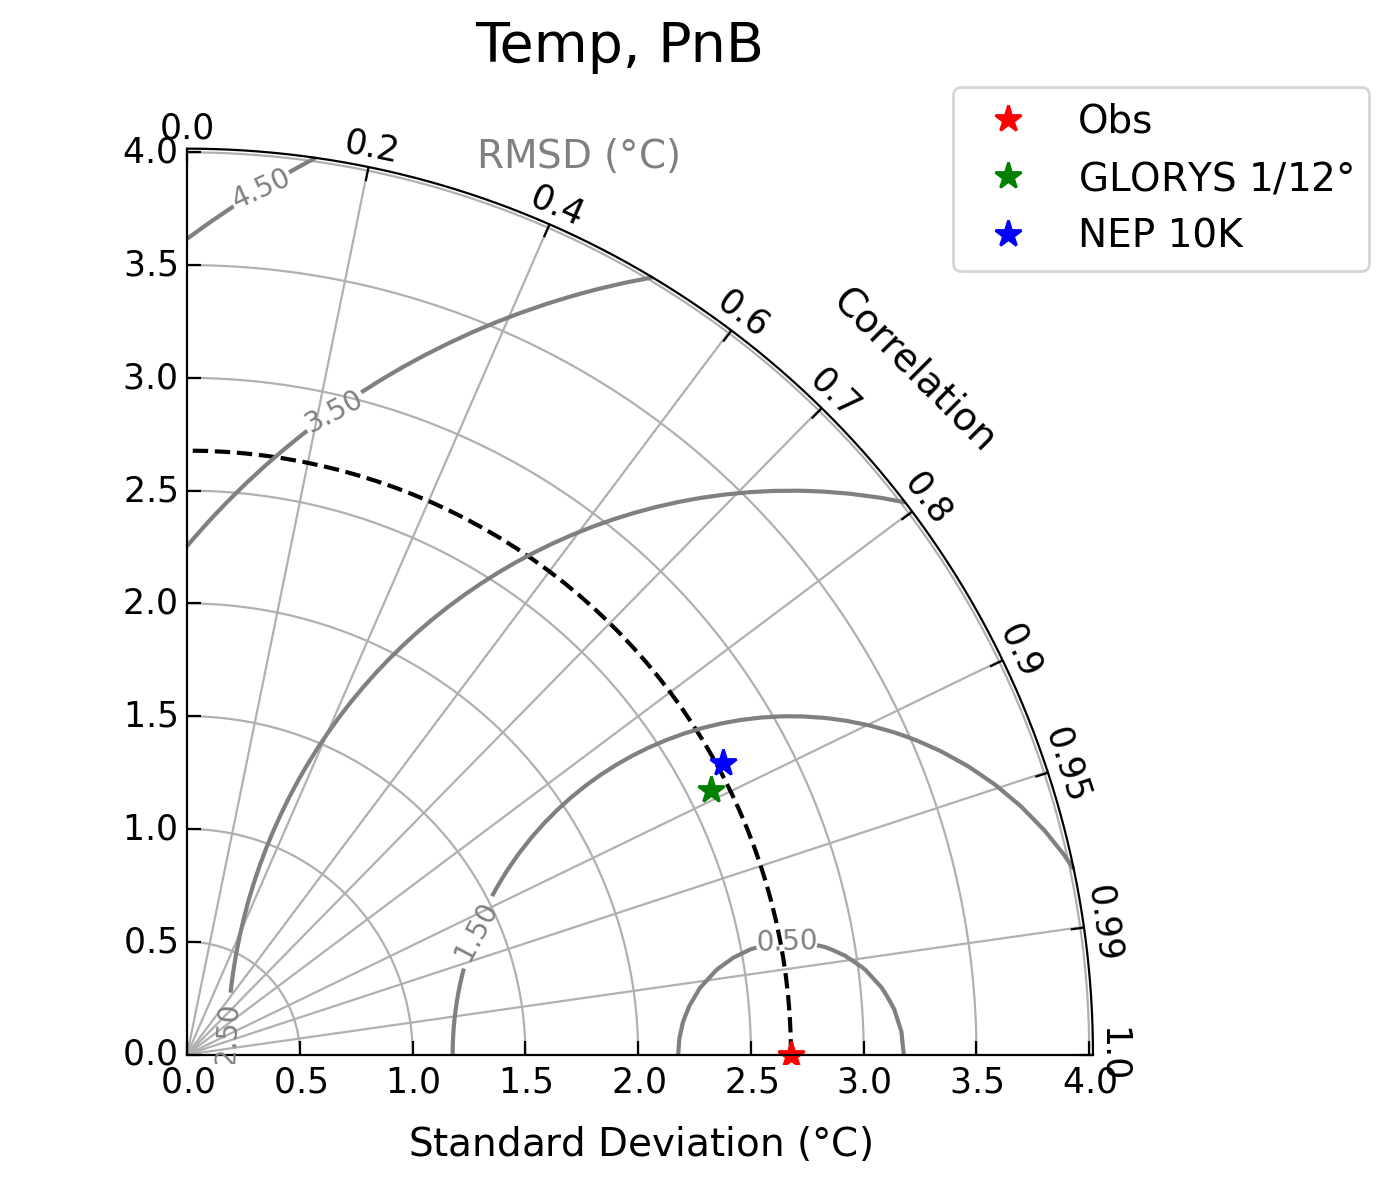

In [24]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))

# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])


fig,axs = plt.subplots(nrows=1,ncols=1)
dia = utils.TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                    srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef, \
                    marker='*', ms=10, ls='', \
                    mfc=colors[i], mec=colors[i], \
                    label=labels[i])
# Add grid
dia.add_grid()
# Add a figure legend
fig.legend(dia.samplePoints,
            [ p.get_label() for p in dia.samplePoints ],
            numpoints=1, loc='upper right',\
                    bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
            ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
            va='center',fontsize=14,rotation=315)
plt.text(0.45,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
            rotation=0,ha='center',fontsize=14)
axs.axis('off')
plt.suptitle(f'{var}, {cruise}',fontsize=20)
outfile=f'PLOTS/{cruise}_{var}_TaylorDiagram.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Scatter Plot

/tmp/ipykernel_3909941/2784616202.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)


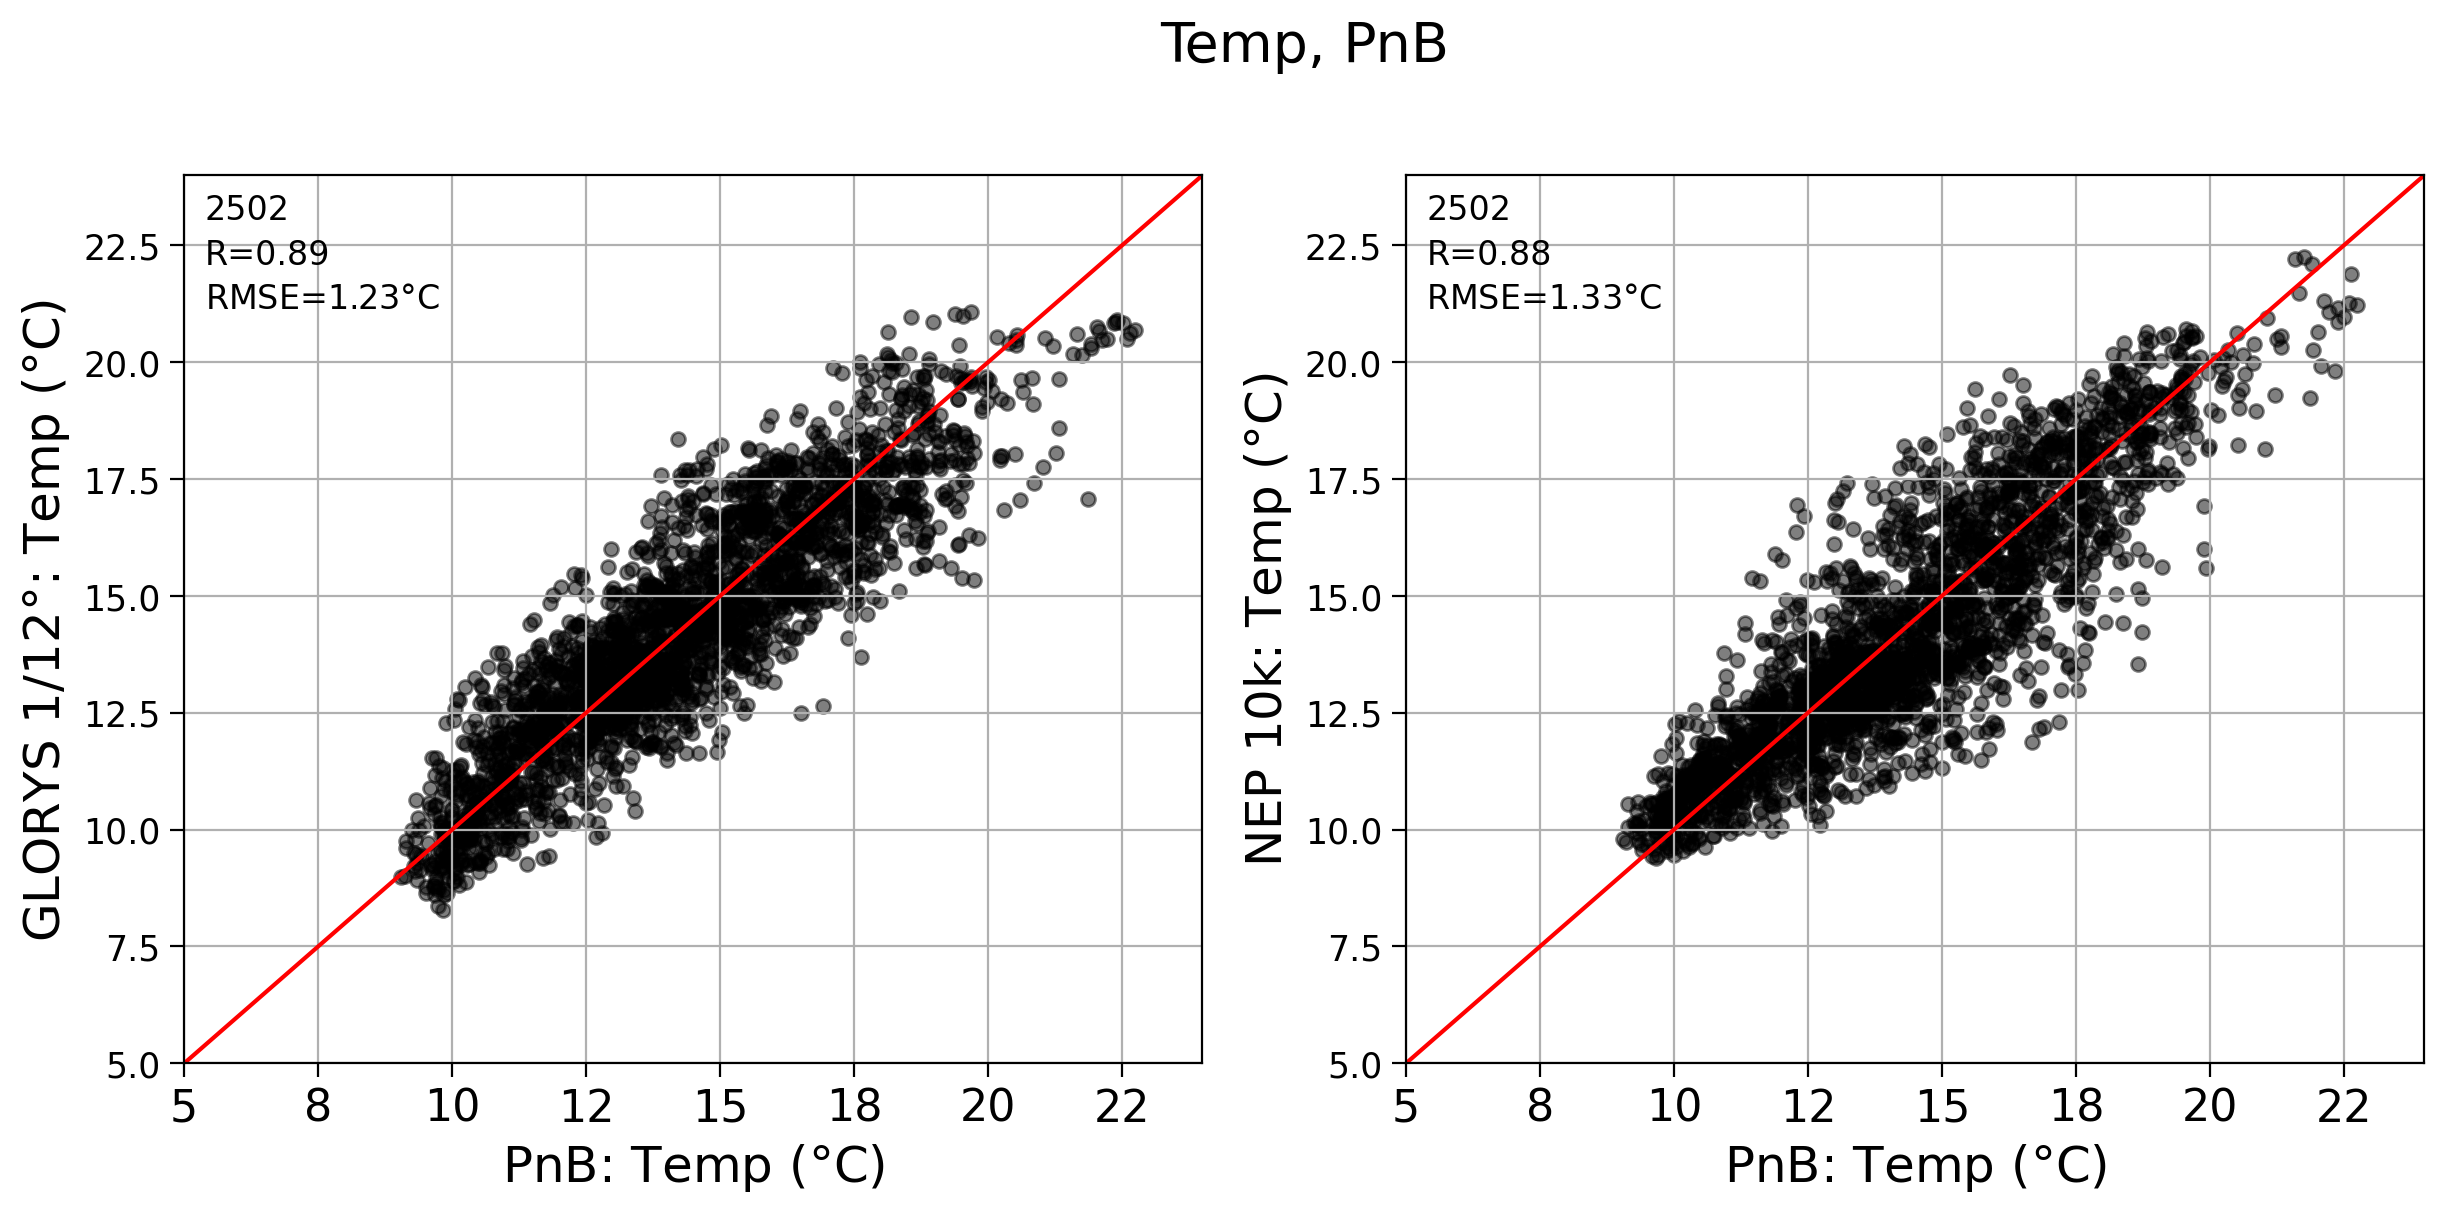

In [25]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,left=0.1,top=0.85,wspace=0.2)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)

axs[0].text(0.02, 0.95,f'{len(xxx1)}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'{len(xxx2)}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)

for i in range(len(axs)):
    axs[i].set_ylim(5,24)
    axs[i].set_xlim(5,24)
    axs[i].grid()
    axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
    axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
    axs[i].set_xlabel(f'{cruise}: {var} ({units})',fontsize=18)

axs[0].set_ylabel(f'GLORYS 1/12$\degree$: {var} ({units})',fontsize=18)
axs[1].set_ylabel(f'NEP 10k: {var} ({units})',fontsize=18)

plt.suptitle(f'{var}, {cruise}',fontsize=20)
outfile=f'PLOTS/{cruise}_{var}_Scatter.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Timeseries SST

In [26]:
station_v=np.arange(1,8,1)

Extract SST and seasonal resample

In [27]:
ooo=obs.isel(depth=0).resample(time='QS-JAN').mean('time').assign_coords({'npts':station_v})
nnn=nep.isel(depth=0).resample(time='QS-JAN').mean('time').assign_coords({'npts':station_v})
ggg=glo.isel(depth=0).resample(time='QS-JAN').mean('time').assign_coords({'npts':station_v})

AdataG=ggg.groupby('time.month')-ggg.groupby('time.month').mean('time')
AdataN=nnn.groupby('time.month')-nnn.groupby('time.month').mean('time')
AdataO=ooo.groupby('time.month')-ooo.groupby('time.month').mean('time')

/tmp/ipykernel_3909941/1834991318.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
/tmp/ipykernel_3909941/1834991318.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_xticklabels(axs[ix].get_xticklabels(),fontsize=16)


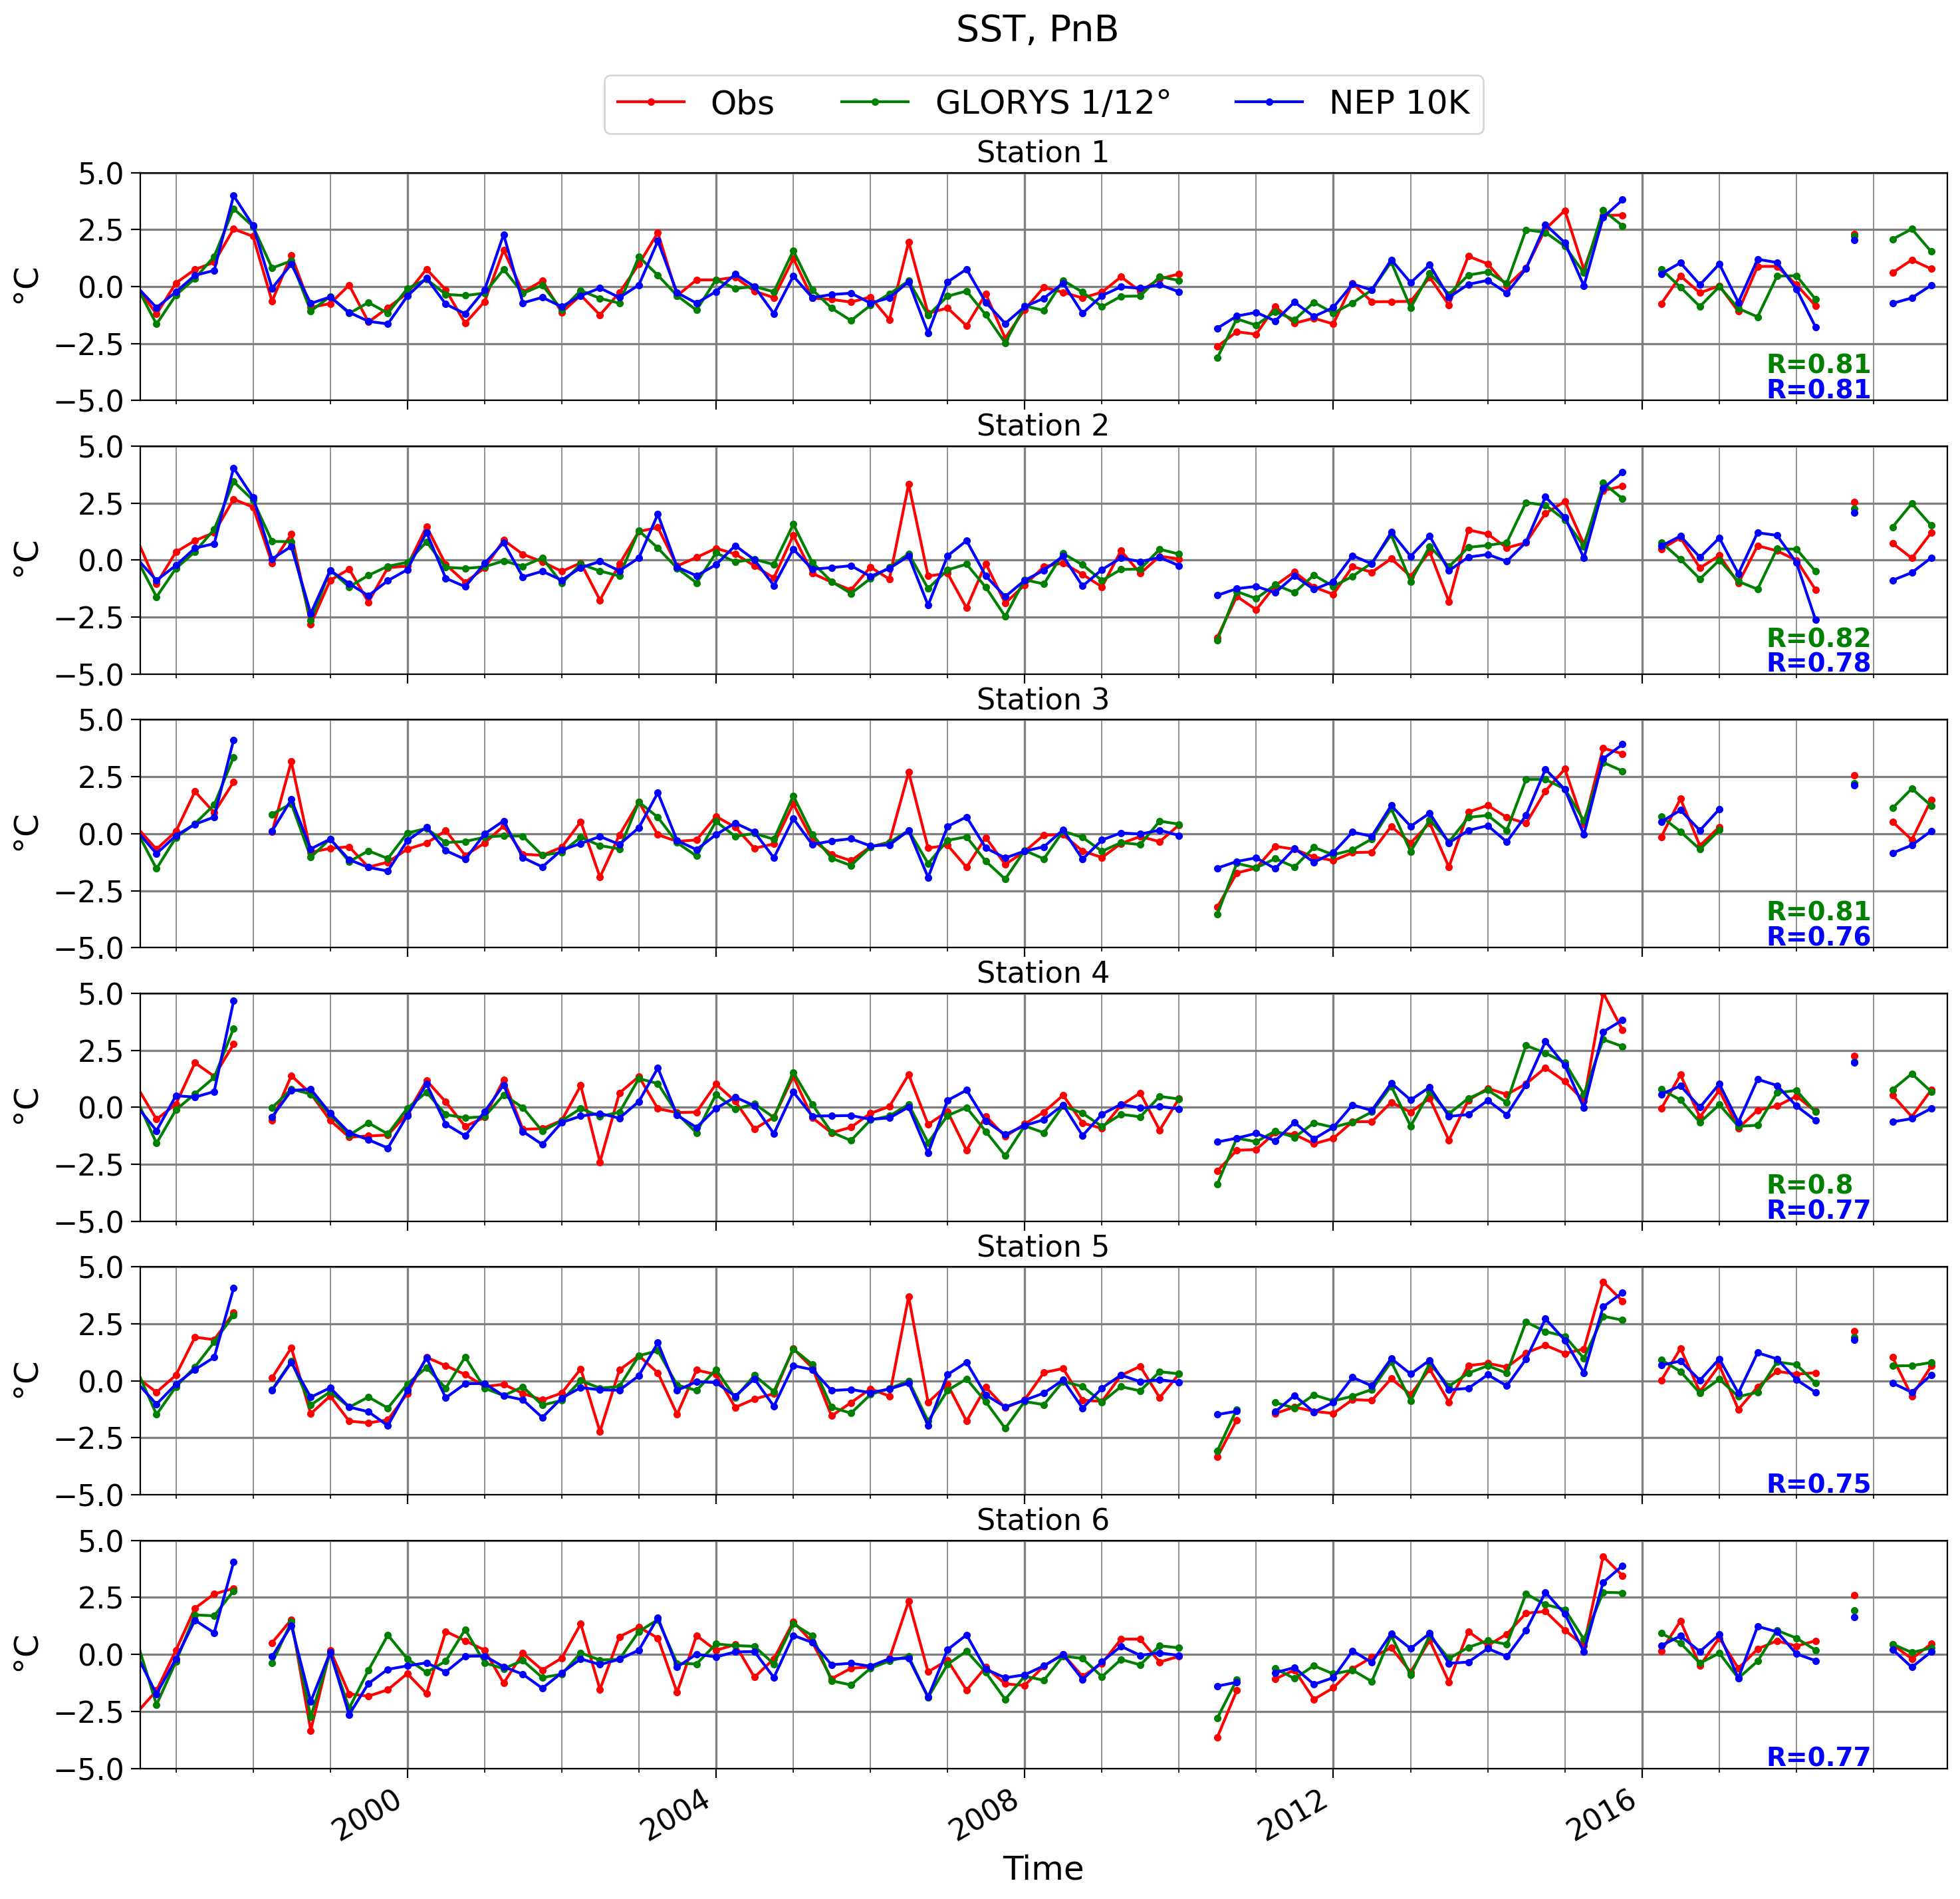

In [28]:
year=DS.indexes['time']
fig, axs =\
plt.subplots(nrows=6,ncols=1,
                        figsize=(18,15),clear=True)
plt.subplots_adjust(bottom=0.1, hspace=0.2,right=0.88, top=0.9)
axs=axs.flatten()
for ipt in range(0,6,1):
  Oo=AdataO.T.isel(npts=ipt)
  Gg=AdataG.T.isel(npts=ipt)
  Nn=AdataN.T.isel(npts=ipt)
  xx1=np.where(np.isnan(Gg)==False)[0]
  xx2=np.where(np.isnan(Nn)==False)[0]
  cor_G=np.round(np.corrcoef(Oo[xx1],Gg[xx1])[0][1],2)
  cor_N=np.round(np.corrcoef(Oo[xx2],Nn[xx2])[0][1],2)
  Oo.plot.line(ax=axs[ipt],c='r',marker='o',markersize=3,label='Obs')
  Gg.plot.line(ax=axs[ipt],c='green',marker='o',markersize=3,label='GLORYS $1/12\degree$')
  Nn.plot.line(ax=axs[ipt],c='blue',marker='o',markersize=3,label='NEP 10K')
  if ipt<4:
    axs[ipt].text(0.9, 0.12,f'R={cor_G}',c='green',transform=axs[ipt].transAxes,\
                weight='bold',fontsize=14)
  axs[ipt].text(0.9, 0.01,f'R={cor_N}',c='blue',transform=axs[ipt].transAxes,\
                weight='bold',fontsize=14)
axs[0].legend(loc='center',ncols=3,\
                       bbox_to_anchor=(0.5,1.3), prop={'size': 18})
for ix in range(0,6):
  axs[ix].grid()
  axs[ix].set_ylim(-5.,5.)
  axs[ix].set_xlim(year[6],year[-1])
  axs[ix].set_title(f'Station {ix+1}',fontsize=16)
  axs[ix].set_ylabel('$\degree$C',size=18)
  axs[ix].xaxis.set_minor_locator(mdates.YearLocator(month=1))
  axs[ix].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  axs[ix].grid(which='major', color='grey', linewidth=1.2)
  axs[ix].grid(which='minor', color='grey', linewidth=0.6)
  #axs[ix].set_yticks(axs[ix].get_yticks()[::2])
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
  if ix==5:
    axs[ix].set_xticklabels(axs[ix].get_xticklabels(),fontsize=16)
    axs[ix].set_xlabel('Time',size=18)
  else:
    axs[ix].set_xticklabels('',fontsize=16)
    axs[ix].set_xlabel('',size=18)
plt.suptitle(f'SST, PnB',fontsize=20)
outfile=f'PLOTS/PnB_A{var}_depth0_timeseries_resample.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Station 4 Profile

In [34]:
clevs=np.arange(6,17,0.2)
clevsa=np.arange(-1.5,1.51,0.01)
clevss=np.arange(0.5,2.4,0.02)
clevssa=np.arange(-1.,1.01,0.01)
#
dataO=obs.isel(npts=3).interpolate_na(dim='depth',method='linear').sel(depth=slice(0,85))
dataG=glo.isel(npts=3).interpolate_na(dim='depth',method='linear').sel(depth=slice(0,85))
dataN=nep.isel(npts=3).interpolate_na(dim='depth',method='linear').sel(depth=slice(0,85))
meanC=dataO.resample(time='QS-JAN').mean('time').groupby('time.month').mean('time')
meanG=dataG.resample(time='QS-JAN').mean('time').groupby('time.month').mean('time')
meanN=dataN.resample(time='QS-JAN').mean('time').groupby('time.month').mean('time')
stdC=dataO.resample(time='QS-JAN').mean('time').groupby('time.month').std('time')
stdG=dataG.resample(time='QS-JAN').mean('time').groupby('time.month').std('time')
stdN=dataN.resample(time='QS-JAN').mean('time').groupby('time.month').std('time')

depth=depth.sel(depth=slice(0,85))
Ts=['JFM','AMJ','JAS','OND']
Tm=[1,4,7,10]

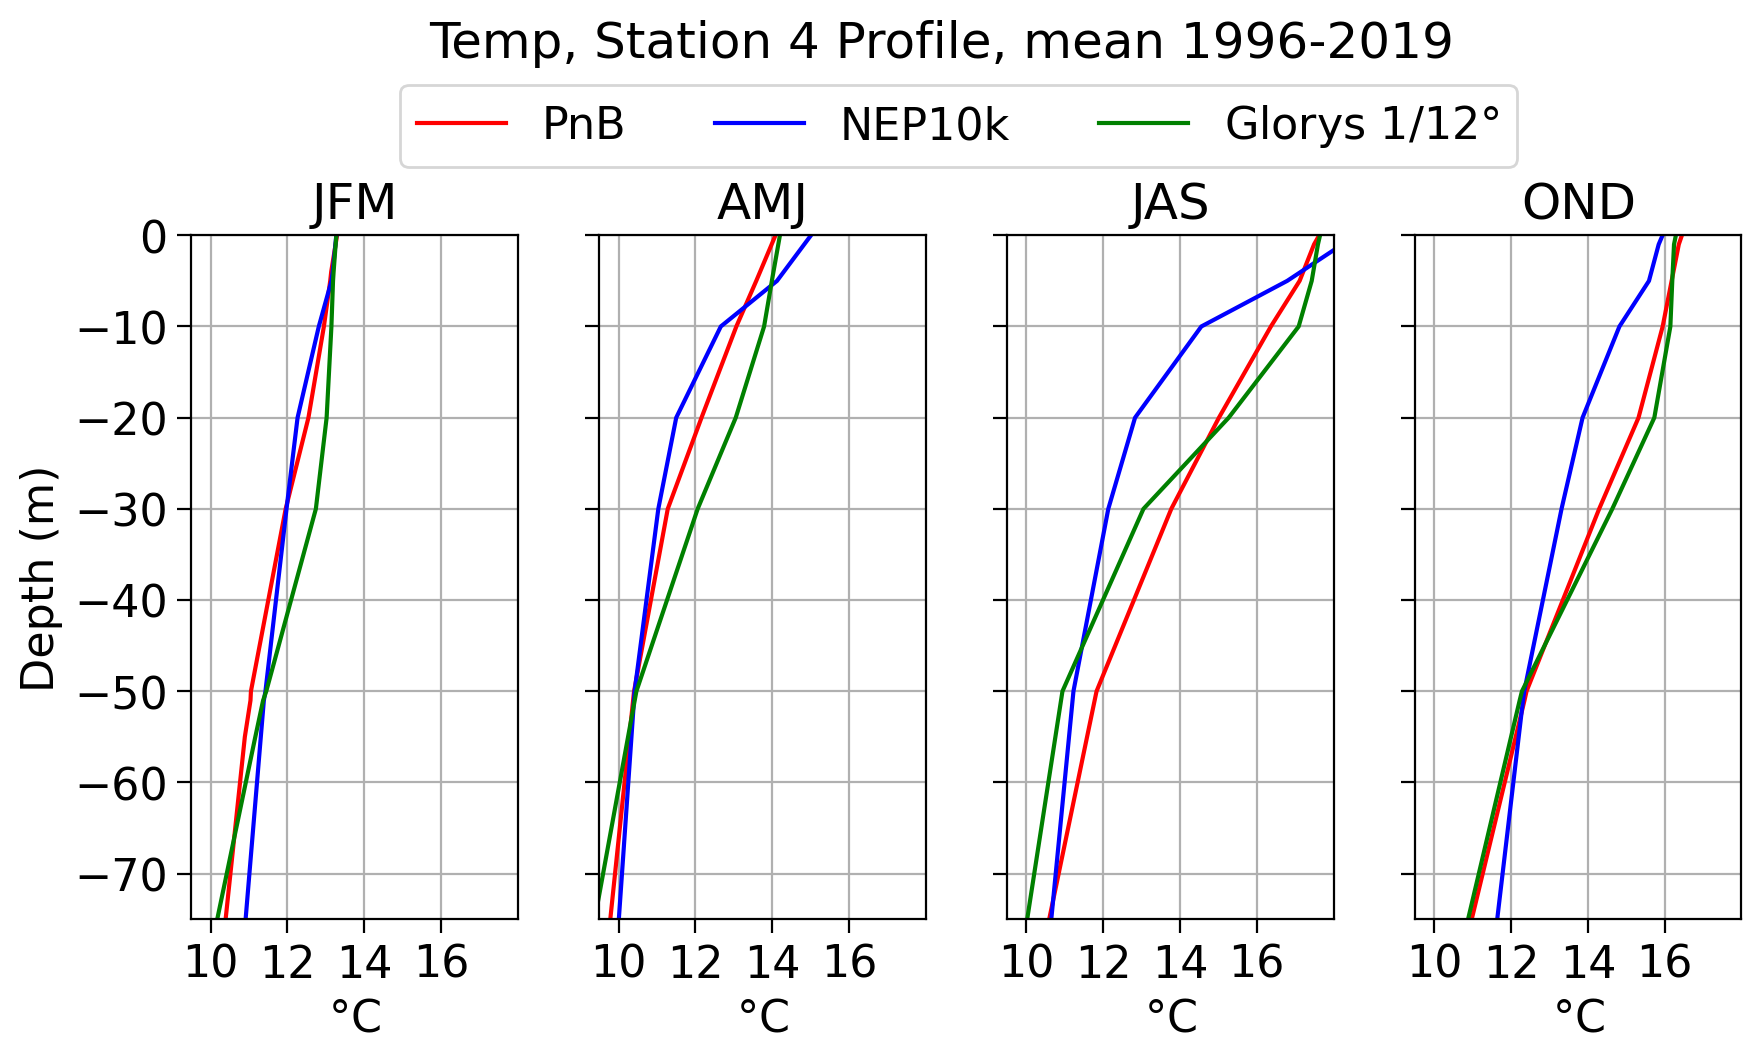

In [35]:
#####
# var
#####
fig,axs=plt.subplots(nrows=1,ncols=4,
                        figsize=(10,6),clear=True)
plt.subplots_adjust(bottom=0.23, right=0.9, top=0.8,hspace=0.1,wspace=0.25)
### Plot the path of the cross section ###
for iq in range(0,4):
  axs[iq].plot(meanC.sel(month=Tm[iq]),-depth,color='r',label=f'{cruise}')
  axs[iq].plot(meanN.sel(month=Tm[iq]),-depth,color='b',label='NEP10k')
  axs[iq].plot(meanG.sel(month=Tm[iq]),-depth,color='g',label='Glorys $1/12\degree$')
  axs[iq].set_ylabel('')
  axs[iq].set_xlabel('')
  axs[iq].set_ylim(-75,0)
  axs[iq].set_xlim(9.5,18)
  axs[iq].set_yticks(np.arange(0,-80,-10))
  axs[iq].set_xticks(np.arange(10,18,2))
  if iq==0:
    axs[iq].yaxis.set_tick_params(labelsize=16)
    axs[iq].set_ylabel(f'Depth (m)',size=16)
  else:
    axs[iq].set_yticklabels('')
  axs[iq].xaxis.set_tick_params(labelsize=16)
  axs[iq].set_xlabel(f'{units}',size=16)
  axs[iq].grid()
  axs[iq].set_title(Ts[iq],fontsize=18)
axs[1].legend(loc='center',ncols=3,\
                       bbox_to_anchor=(1.1,1.16), prop={'size': 16})
plt.suptitle(f'{var}, Station 4 Profile, mean 1996-2019',fontsize=18)
outfile=f'PLOTS/{var}_Xsection_multiMod_Station4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

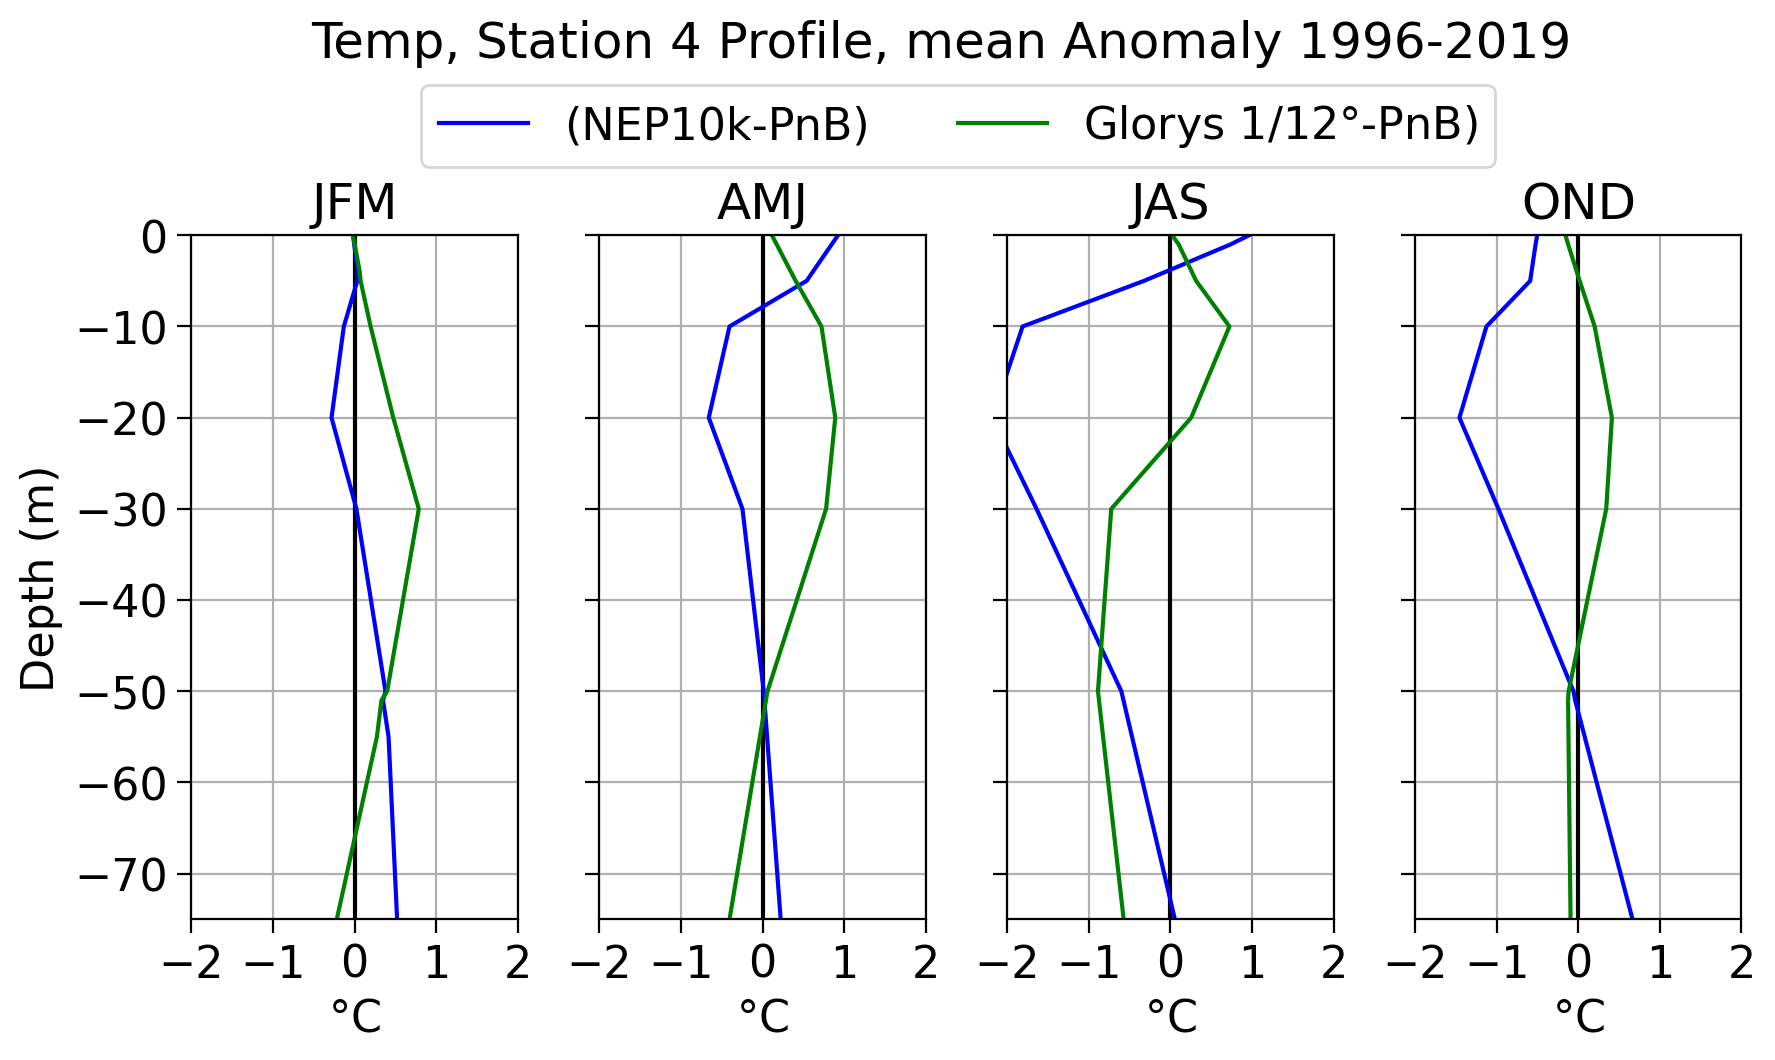

In [37]:
#####
# Avar
#####
fig,axs=plt.subplots(nrows=1,ncols=4,figsize=(10,6))
plt.subplots_adjust(bottom=0.23, right=0.9, top=0.8,hspace=0.1,wspace=0.25)
### Plot the path of the cross section ###
for iq in range(0,4):
  axs[iq].plot(meanC.sel(month=Tm[iq])-meanC.sel(month=Tm[iq]),-depth,color='k')
  axs[iq].plot(meanN.sel(month=Tm[iq])-meanC.sel(month=Tm[iq]),-depth,color='b',label=f'(NEP10k-{cruise})')
  axs[iq].plot(meanG.sel(month=Tm[iq])-meanC.sel(month=Tm[iq]),-depth,color='g',label=f'Glorys $1/12\degree$-{cruise})')
  axs[iq].set_ylabel('')
  axs[iq].set_xlabel('')
  axs[iq].set_ylim(-75,0)
  axs[iq].set_xlim(-2,2)
  axs[iq].set_yticks(np.arange(0,-80,-10))
  if iq==0:
    axs[iq].yaxis.set_tick_params(labelsize=16)
    axs[iq].set_ylabel(f'Depth (m)',size=16)
  else:
    axs[iq].set_yticklabels('')
  axs[iq].set_xticks(np.arange(-2,3,1))
  axs[iq].xaxis.set_tick_params(labelsize=16)
  axs[iq].set_xlabel(f'{units}',size=16)
  axs[iq].grid()
  axs[iq].set_title(Ts[iq],fontsize=18)
axs[1].legend(loc='center',ncols=3,\
                       bbox_to_anchor=(1.1,1.16), prop={'size': 16})
plt.suptitle(f'{var}, Station 4 Profile, mean Anomaly 1996-2019',fontsize=18)
outfile=f'PLOTS/A{var}_Xsection_multiMod_Station4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

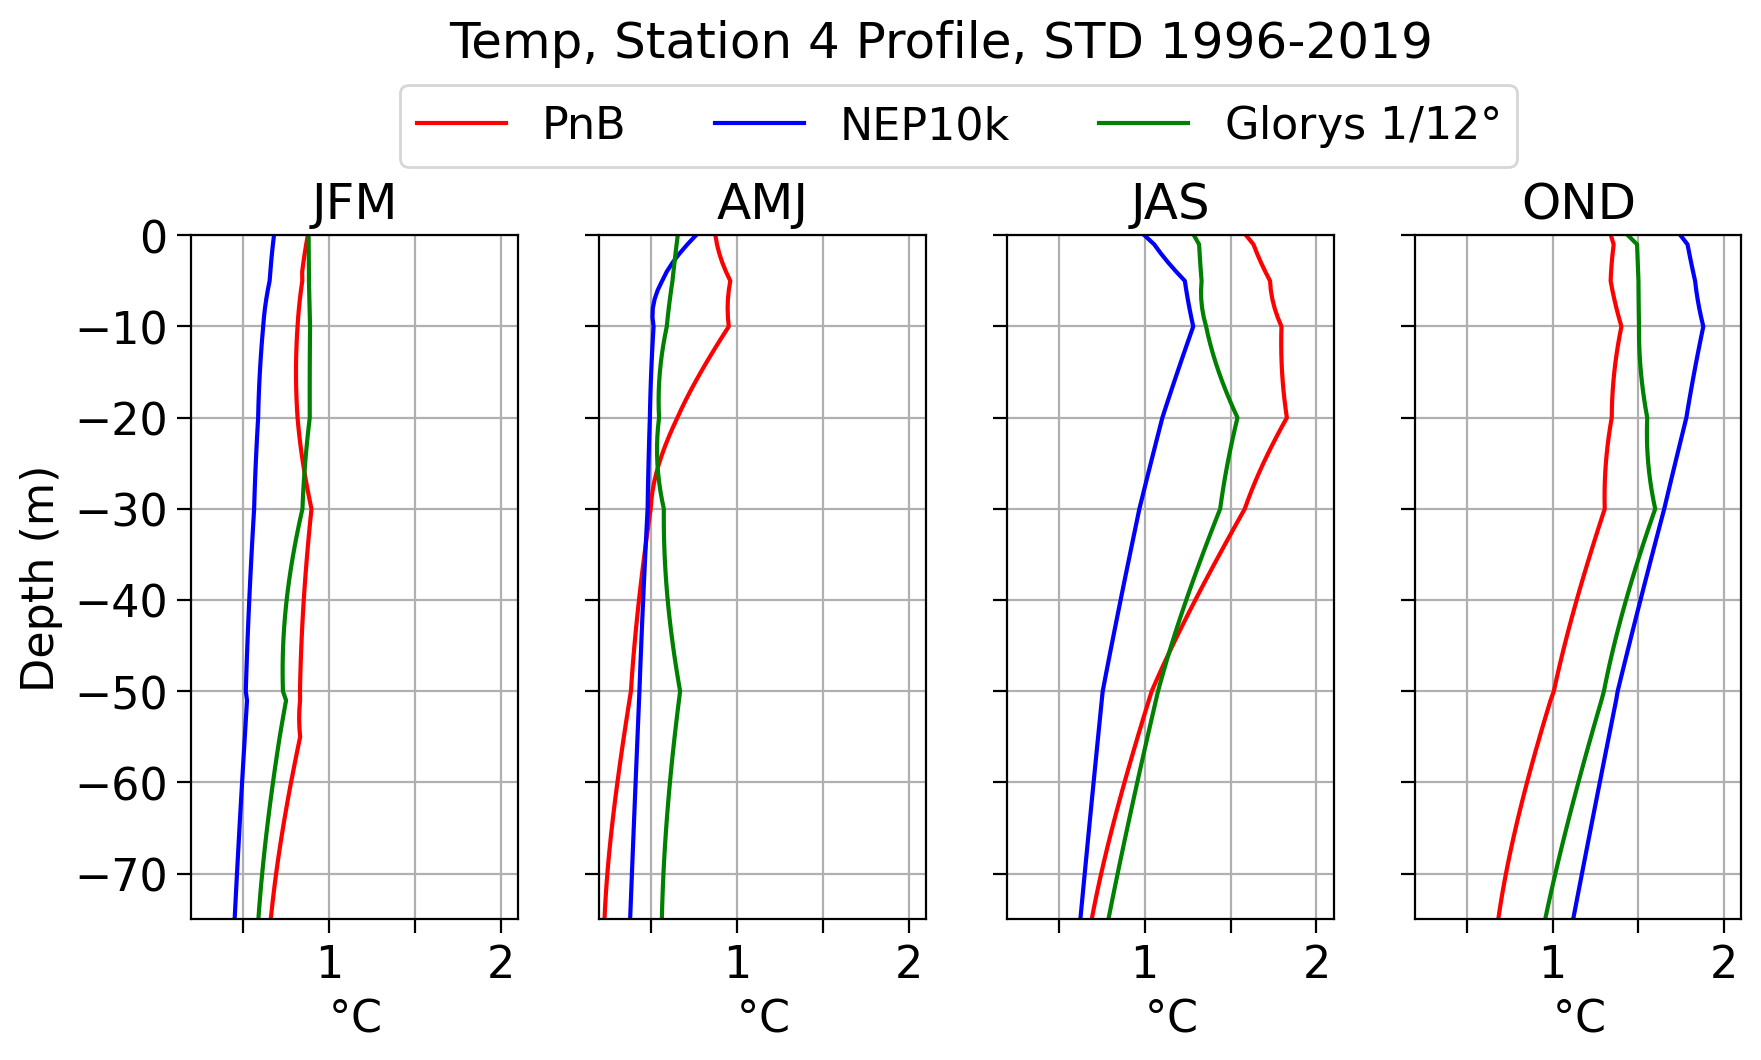

In [43]:
#####
# std var
#####
fig,axs=plt.subplots(nrows=1,ncols=4,
                        figsize=(10,6),num=3,clear=True)
plt.subplots_adjust(bottom=0.23, right=0.9, top=0.8,hspace=0.1,wspace=0.25)
### Plot the path of the cross section ###
for iq in range(0,4):
  axs[iq].plot(stdC.sel(month=Tm[iq]),-depth,color='r',label=f'{cruise}')
  axs[iq].plot(stdN.sel(month=Tm[iq]),-depth,color='b',label='NEP10k')
  axs[iq].plot(stdG.sel(month=Tm[iq]),-depth,color='g',label='Glorys $1/12\degree$')
  axs[iq].set_ylabel('')
  axs[iq].set_xlabel('')
  axs[iq].set_ylim(-75,0)
  axs[iq].set_xlim(0.2,2.1)
  axs[iq].set_yticks(np.arange(0,-80,-10))
  axs[iq].set_xticks(np.arange(0.5,2.5,0.5))
  if iq==0:
    axs[iq].yaxis.set_tick_params(labelsize=16)
    axs[iq].set_ylabel(f'Depth (m)',size=16)
  else:
    axs[iq].set_yticklabels('')
  axs[iq].set_xticklabels(['','1','','2'],fontsize=16)
  axs[iq].set_xlabel(f'{units}',size=16)
  axs[iq].grid()
  axs[iq].set_title(Ts[iq],fontsize=18)
axs[1].legend(loc='center',ncols=3,\
                       bbox_to_anchor=(1.1,1.16), prop={'size': 16})
plt.suptitle(f'{var}, Station 4 Profile, STD 1996-2019',fontsize=18)
outfile=f'PLOTS/STD{var}_Xsection_multiMod_Station4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

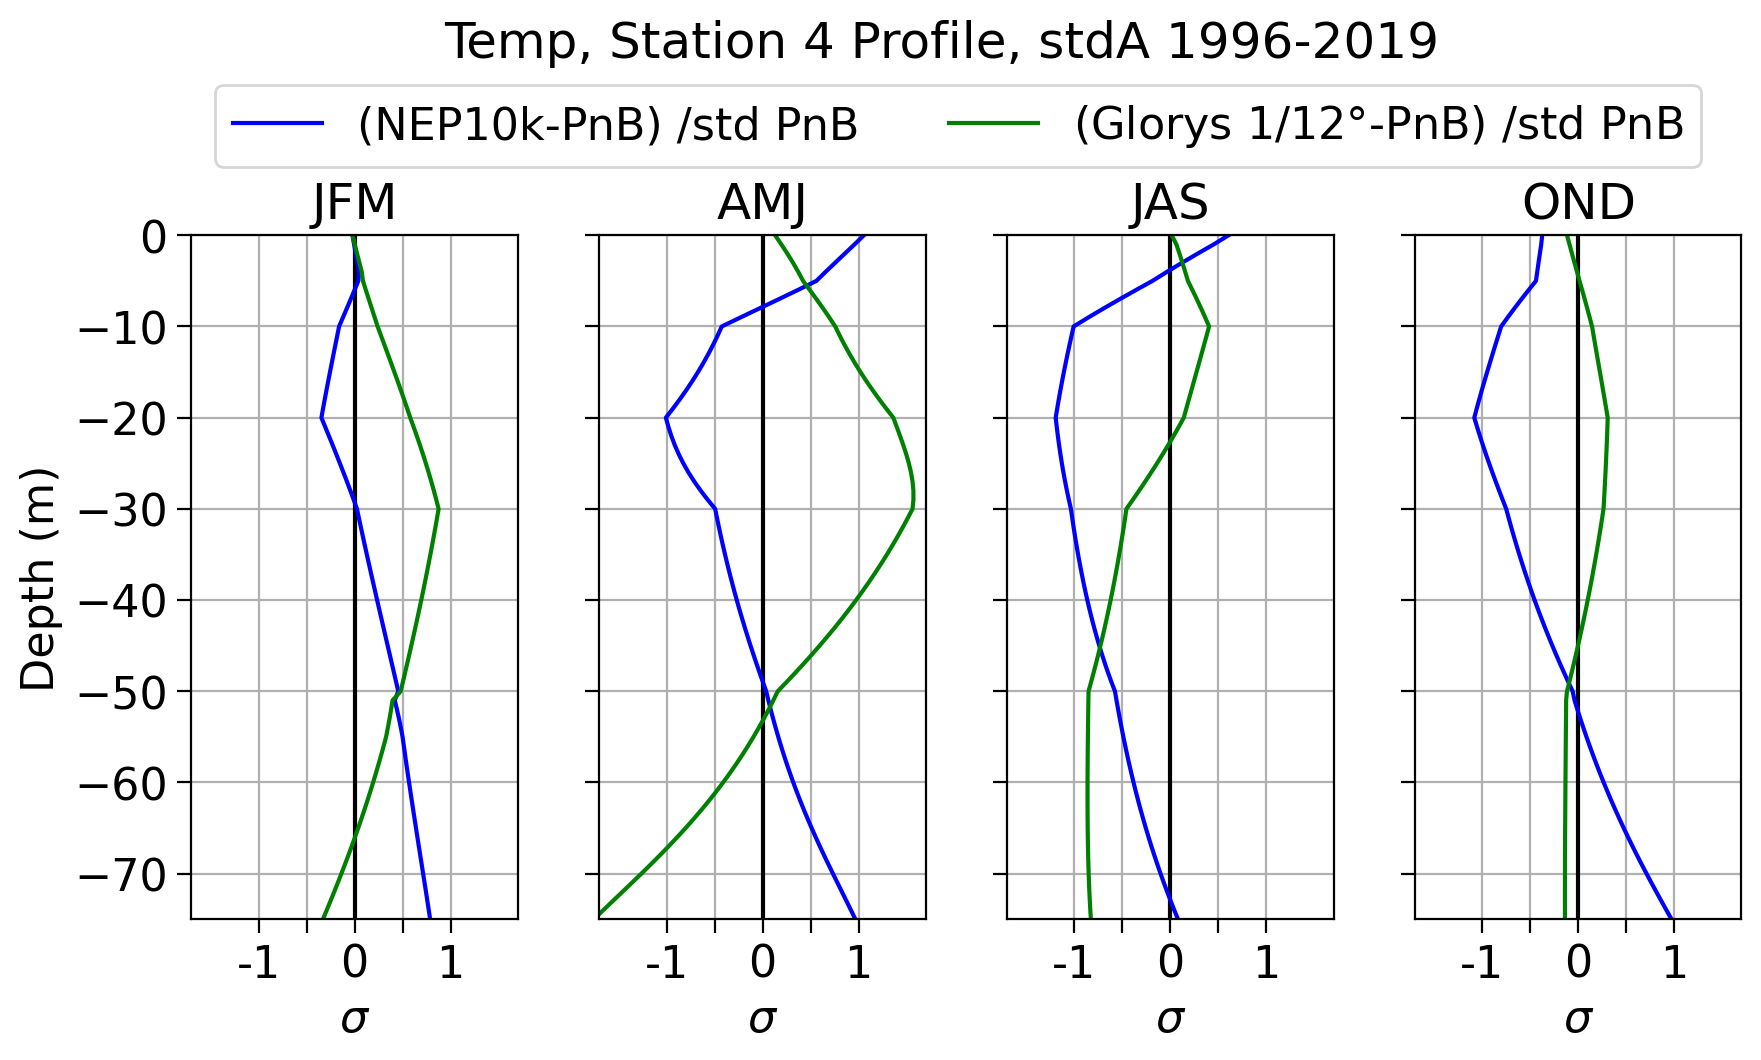

In [42]:
#####
# A std var
#####
fig,axs=plt.subplots(nrows=1,ncols=4,
                        figsize=(10,6),num=3,clear=True)
plt.subplots_adjust(bottom=0.23, right=0.9, top=0.8,hspace=0.1,wspace=0.25)
### Plot the path of the cross section ###
for iq in range(0,4):
  axs[iq].plot((meanC.sel(month=Tm[iq])-meanC.sel(month=Tm[iq])),-depth,color='k')
  axs[iq].plot((meanN.sel(month=Tm[iq])-meanC.sel(month=Tm[iq]))/
                stdC.sel(month=Tm[iq]),-depth,color='b',label=f'(NEP10k-{cruise}) /std {cruise}')
  axs[iq].plot((meanG.sel(month=Tm[iq])-meanC.sel(month=Tm[iq]))/
                stdC.sel(month=Tm[iq]),-depth,color='g',label=f'(Glorys $1/12\degree$-{cruise}) /std {cruise}')
  axs[iq].set_ylabel('')
  axs[iq].set_xlabel('')
  axs[iq].set_ylim(-75,0)
  axs[iq].set_xlim(-1.7,1.7)
  axs[iq].set_yticks(np.arange(0,-80,-10))
  if iq==0:
    axs[iq].yaxis.set_tick_params(labelsize=16)
    axs[iq].set_ylabel(f'Depth (m)',size=16)
  else:
    axs[iq].set_yticklabels('')
  axs[iq].set_xticks(np.arange(-1,1.5,0.5))
  axs[iq].set_xticklabels(['-1','','0','','1'],fontsize=16)
  axs[iq].set_xlabel(f'$\sigma$',size=16)
  axs[iq].grid()
  axs[iq].set_title(Ts[iq],fontsize=18)
axs[1].legend(loc='center',ncols=3,\
                       bbox_to_anchor=(1.1,1.16), prop={'size': 16})
plt.suptitle(f'{var}, Station 4 Profile, stdA 1996-2019',fontsize=18)
outfile=f'PLOTS/STDA{var}_Xsection_multiMod_Station4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')